<a href="https://colab.research.google.com/github/nsubbaian/FrequentistML/blob/master/Project4/FML_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4: xTreme Gradient Boosted Trees**

Using out of the box package for xTreme gradient boosting trees: https://xgboost.readthedocs.io/en/latest/.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

SEED = 42

# Selected Dataset: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
# Dataset Description: https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names
# Chosen so it's good for regression (with numerical, not categorical features, and the target is a continuous number)

dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

# removed categorical feautures
dataset = dataset.drop(columns = {'month', 'day'})

# Shuffle and then split training data into 80% train, 10% validation and 10% test
training, validation, test = np.split(dataset.sample(frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])
print("Length of dataset:", len(dataset))
print( "Length of training:", len(training))
print("Length of validation:", len(validation))
print("Length of test:", len(test))

training.head()

Length of dataset: 517
Length of training: 413
Length of validation: 52
Length of test: 52


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
463,6,5,75.1,4.4,16.2,1.9,4.6,82,6.3,0.0,5.39
51,4,3,90.2,99.6,631.2,6.3,21.5,34,2.2,0.0,0.00
458,8,6,93.7,231.1,715.1,8.4,18.9,64,4.9,0.0,3.32
324,6,5,88.1,53.3,726.9,5.4,13.7,56,1.8,0.0,4.42
359,1,4,92.5,122.0,789.7,10.2,21.1,39,2.2,0.0,8.12


best lambda 1e-15
TEST MSE 1.4532020934948007


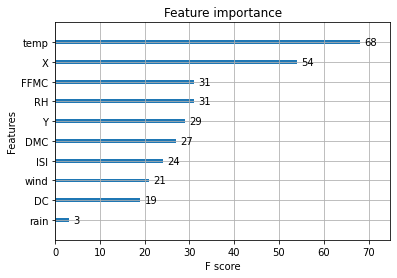

In [14]:
XGBtrain_X, XGBtrain_Y = training.iloc[:, :10], np.log(training.iloc[:, 10]+ 1)
XGBval_X, XGBval_Y = validation.iloc[:, :10], np.log(validation.iloc[:, 10]+1)
XGBtest_X, XGBtest_Y = test.iloc[:, :10], np.log(test.iloc[:, 10]+1)

dtrain = xgb.DMatrix(XGBtrain_X, label=XGBtrain_Y)
dtest = xgb.DMatrix(XGBtest_X, label=XGBtest_Y)
dval = xgb.DMatrix(XGBval_X, XGBval_Y)

# tune your regression method - selecting optimal L1 regularization term on weights.
bestMSE = float('inf')
for lam in [1e-15, 1e-5, .1, 1, 5, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 30, 35, 50, 100]:
  param = {'max_depth': 6, 'min_child_weight': 1, 'eta': .3, 
          'objective': 'reg:squarederror',
          'reg_alpha' : lam}
  evallist = [ (dval, 'val')]

  # uses early stopping to find the optimal number of boosting rounds
  bst = xgb.train(param, dtrain, num_boost_round = 50, evals = evallist, 
                  early_stopping_rounds = 10, verbose_eval = False)
  
  XGBMSE = bst.best_score
  if (XGBMSE < bestMSE):
    bestLambda = lam
    bestMSE = XGBMSE
print("best lambda", bestLambda)


# Report your performance and output the feature importance
param = {'max_depth': 6, 
          'min_child_weight': 1,
          'eta': .3, 
          'objective': 'reg:squarederror',
          'reg_alpha' : bestLambda}
evallist = [(dtrain, 'train'), (dval, 'val')]
bst = xgb.train(param, dtrain, num_boost_round = 50, evals = evallist, 
                early_stopping_rounds = 10, verbose_eval = False)


ypred = bst.predict(xgb.DMatrix(XGBtest_X), ntree_limit=bst.best_ntree_limit)
XGBMSE_test = np.square(np.subtract(XGBtest_Y, ypred)).mean()
print("TEST MSE", XGBMSE_test)

xgb.plot_importance(bst)


Do the features reported make sense? If you are using the same dataset from assignment 1 or 2, do they agree with what you discovered using the Lasso penalty?

For this assignment I used the same dataset as I did in Assignment 1. 

In some runs, temp is the number one feature, in other runs RH is the number one feature. Both features intuitively make sense, as temperature, especially if it's hot can cause a fire. RH is relative humidity in %: 15.0 to 100, according to https://www.nwcg.gov/ . However, these features are not the same as the features with the highest coefficients for Lasso Regression in Assignment 1. However, RH was one of the four chosen features that predicted small forest fires the best in http://www3.dsi.uminho.pt/pcortez/fires.pdf . 


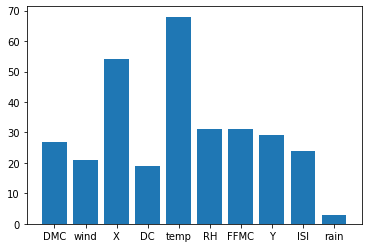

In [15]:
# plot - ‘weight’: the number of times a feature is used to split the data across all trees.
feat_imp = bst.get_score(importance_type='weight')
plt.bar(feat_imp.keys(), feat_imp.values())
plt.show()

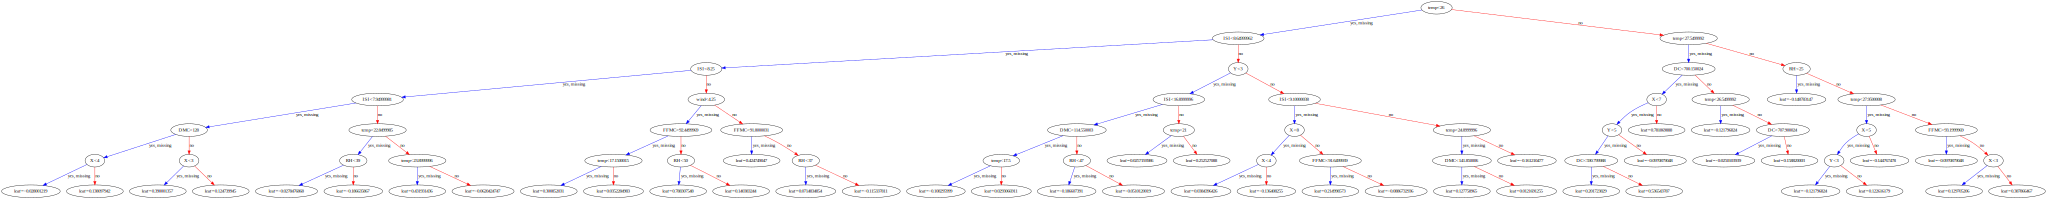

In [16]:
xgb.to_graphviz(bst, num_trees=2)